<a href="https://colab.research.google.com/github/eohta/udemy-numpyro-basic/blob/main/02_plants/01_fit_poisson_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package Installation

In [1]:
# !pip install numpyro

インストール完了後にランタイムを再スタートして下さい！

## Import Packages

In [2]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import jax
# jax.config.update('jax_default_device', jax.devices('cpu')[0])

In [4]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [5]:
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
plt.rcParams['font.size'] = 12

## Load & Check Data

In [7]:
data = pd.DataFrame({
    
    'yield':[ 7, 13, 13, 11,  5,  6,  8, 11, 10, 11, 11, 11, 11, 14,  8, 15, 10,
        9, 13, 12,  8, 15,  7, 11,  5, 11, 15, 10, 13,  9,  8, 12, 13,  6,
        8,  5, 13,  8,  5, 10, 18,  9,  7, 12, 11,  5,  9, 10, 13, 13,  7,
       12,  8, 16, 10,  6, 12, 13, 10, 12,  9,  7, 12, 11,  8, 15, 13, 11,
        9, 17, 11, 10, 15, 19, 11, 13, 12,  9, 10, 10],
    
    'group':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
})

In [8]:
data.head(80)

,yield,group
0,7,0
1,13,0
2,13,0
3,11,0
4,5,0
...,...,...
75,13,1
76,12,1
77,9,1
78,10,1


In [9]:
y = data.query('group == 0')['yield'].values

print(y)

[ 7 13 13 11  5  6  8 11 10 11 11 11 11 14  8 15 10  9 13 12  8 15  7 11
  5 11 15 10 13  9  8 12 13  6  8  5 13  8  5 10 18  9  7 12 11  5  9 10
 13 13]


In [10]:
np.mean(y)

np.float64(10.16)

In [11]:
np.var(y)

np.float64(9.1744)

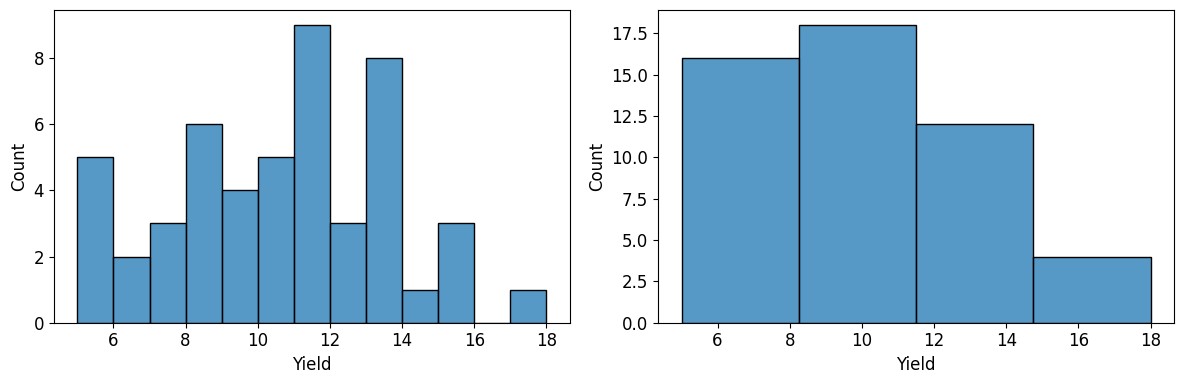

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(y, binwidth=1, ax=axes[0])
axes[0].set_xlabel('Yield')

sns.histplot(y, binwidth=3, ax=axes[1])
axes[1].set_xlabel('Yield')

plt.tight_layout()

## Define Model & Inference

In [13]:
def model(y=None, num_data=0):
    
    # Since the Poisson rate parameter must be ≥ 0, using HalfNormal ensures positivity.
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    
    # This is vectorizing the next operation over num_data points — equivalent to looping over the data.
    # n probabilistic terms, you're saying:
    # I have num_data independent observations from the same distribution.
    
    with numpyro.plate('data', num_data):
    
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

In [14]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [15]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Check MCMC-samples

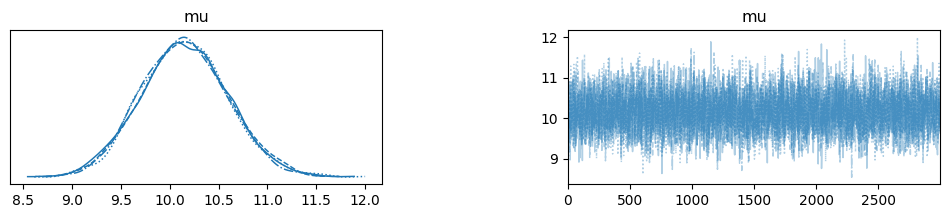

In [16]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [17]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.155,0.445,9.322,10.991,0.006,0.004,4902.0,6320.0,1.0


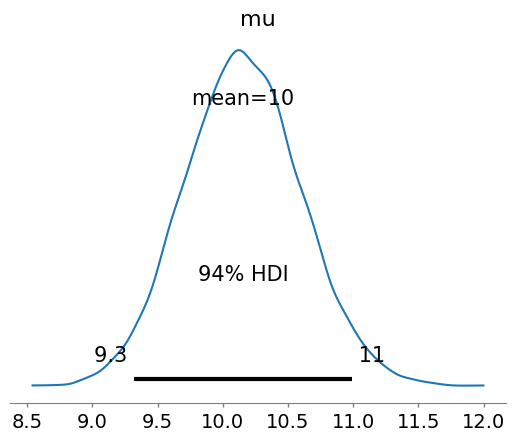

In [18]:
az.plot_posterior(idata);
#az.plot_posterior(idata, hdi_prob=0.95);

In [ ]:
idata

In [ ]:
idata.posterior['mu']

## Posterior Predictive Check

In [ ]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

ppc_samples = predictive(jax.random.PRNGKey(1), num_data=len(y))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [ ]:
ppc_samples['obs'].shape

In [ ]:
ppc_mean = ppc_samples['obs'].mean(axis=1)
ppc_var = ppc_samples['obs'].var(axis=1)

In [ ]:
ppc_mean.shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(y.mean(), color='r', linestyle='dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(y.var(), color='r', linestyle='dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

In [ ]:
idata_ppc

In [ ]:
# 分布によるチェック

az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=50, figsize=(12, 4));

In [ ]:
az.plot_ppc(idata_ppc, kind='kde', num_pp_samples=3000, figsize=(12, 4));